In [ ]:
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incompleteKLL474/caltech_birds2010-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incompleteKLL474/caltech_birds2010-test.tfrecord


Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


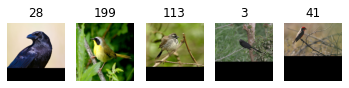

In [ ]:
n_classes=200

#~~~~~~~~~~~~~~~~~~~~~~~load data
test_set = tfds.load('caltech_birds2010', batch_size=32,as_supervised=True,shuffle_files=True, split='test')
valid_set = tfds.load('caltech_birds2010', batch_size=32,as_supervised=True,shuffle_files=True,split='train[10%:20%]')
train_set = tfds.load('caltech_birds2010', batch_size=32,as_supervised=True,shuffle_files=True,split='train[20%:]')

train_set = train_set.shuffle(1000).prefetch(1)

for images, labels in train_set.take(1):
  for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ...]
        label = labels[index].numpy()
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~add to your preprocessing fxn the pretrained model's associated preprocessing steps as well
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224]) #xception expects images to be this size
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label
#~~~~~~~~~~~~~~~~~~~~map the preprocessing fxn across elements of dataset
train_set = train_set.map(preprocess).prefetch(1)
valid_set = valid_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)
#~~~~~~~~~~~~~~~~~~~create model, replacing 2 topmost layers
base_model =keras.applications.xception.Xception(weights='imagenet',include_top=False)#exclude global avg pooling and output layer in order to retrain this 71 layer deep, general classification model for identifiying flowers
avg= keras.layers.GlobalAveragePooling2D()(base_model.output)#replace global avg pooling layer that was excluded
output=keras.layers.Dense(n_classes, activation='softmax')(avg)
model=keras.Model(inputs=base_model.input,  outputs=output)

#~~~~~~~~~~~~~~~~~~~set bottom layers to untrainable for first few epochs
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
#~~~~~~~~~~~~~~~~~~~fit
optimizer = keras.optimizers.Nadam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics='accuracy')
history_1 = model.fit(train_set,epochs=5,validation_data=valid_set)

#~~~~~~~~~~~~~~~~~~set bottom layers trainable
for layer in base_model.layers:
  layer.trainable=False

#~~~~~~~~~~~~~~~~~~continue fit
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("caltech_birds_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "caltech_birds_logs{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history_2 = model.fit(train_set,epochs=300,validation_data=valid_set,callbacks = [model_checkpoint_cb, tensorboard_cb])

In [ ]:
#~~~~~~~~~~~~~~~~~~evaluate
pd.DataFrame(history_1.history).plot()
pd.DataFrame(history_2.history).plot()